# Cybersecurity Threat Detection – Round 2
This notebook detects suspicious user behavior (e.g., too many failed login attempts) using machine learning (Isolation Forest).


In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Show plots inside the notebook
%matplotlib inline

In [4]:
# Load your Excel file (it should be in the same folder)
df = pd.read_excel("system_logs.xecel.xlsx")
df.head()

,timestamp,user,ip_address,action,status
0,2025-07-11 10:02:01,admin,192.168.1.10,login_attempt,failed
1,2025-07-11 10:02:05,admin,192.168.1.10,login_attempt,failed
2,2025-07-11 10:02:10,admin,192.168.1.10,login_attempt,success
3,2025-07-11 10:05:00,guest,192.168.1.12,file_access,success
4,2025-07-11 10:06:30,guest,192.168.1.12,file_access,success


In [5]:
# Filter rows where action is 'login_attempt'
login_df = df[df['action'] == 'login_attempt']
login_df.head()

,timestamp,user,ip_address,action,status
0,2025-07-11 10:02:01,admin,192.168.1.10,login_attempt,failed
1,2025-07-11 10:02:05,admin,192.168.1.10,login_attempt,failed
2,2025-07-11 10:02:10,admin,192.168.1.10,login_attempt,success
5,2025-07-11 10:10:00,tester,192.168.1.14,login_attempt,failed
6,2025-07-11 10:10:05,tester,192.168.1.14,login_attempt,failed


In [6]:
# Filter failed attempts and count by user and IP
failures = login_df[login_df['status'] == 'failed']
grouped = failures.groupby(['user', 'ip_address']).size().reset_index(name='fail_count')
grouped

,user,ip_address,fail_count
0,admin,192.168.1.10,2
1,tester,192.168.1.14,3


In [7]:
# Anomaly detection: users with unusually high failed attempts
model = IsolationForest(contamination=0.2, random_state=42)
grouped['anomaly'] = model.fit_predict(grouped[['fail_count']])
grouped

,user,ip_address,fail_count,anomaly
0,admin,192.168.1.10,2,1
1,tester,192.168.1.14,3,1


In [8]:
# Show users/IPs flagged as suspicious
anomalies = grouped[grouped['anomaly'] == -1]
print("🚨 Anomalies Detected:")
anomalies

🚨 Anomalies Detected:


,user,ip_address,fail_count,anomaly


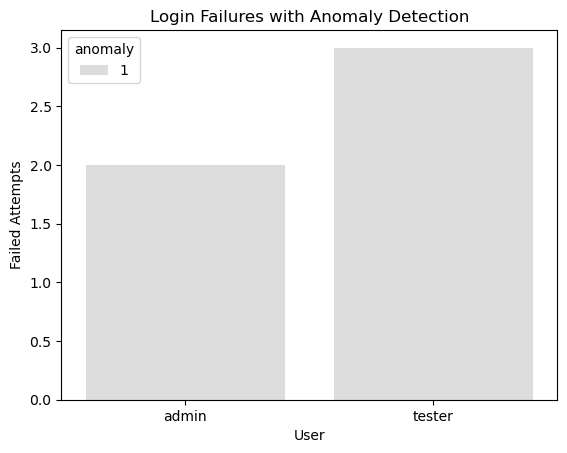

In [9]:
# Bar plot of failed attempts, highlighting anomalies
sns.barplot(x='user', y='fail_count', hue='anomaly', data=grouped, palette='coolwarm')
plt.title("Login Failures with Anomaly Detection")
plt.xlabel("User")
plt.ylabel("Failed Attempts")
plt.show()

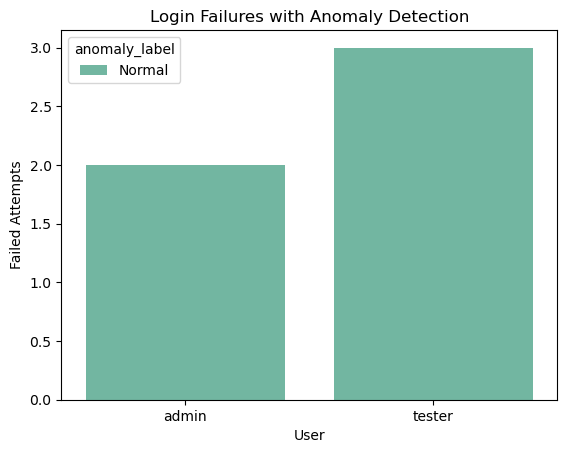

In [10]:
# Convert -1 and 1 to labels for better coloring
grouped['anomaly_label'] = grouped['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})

# Now plot using the labeled version
sns.barplot(x='user', y='fail_count', hue='anomaly_label', data=grouped, palette='Set2')
plt.title("Login Failures with Anomaly Detection")
plt.xlabel("User")
plt.ylabel("Failed Attempts")
plt.show()